# Task 1

* Name:Bhavna Balakrishnan
* Student ID:33954437

In [1]:
from IPython.display import Image
from pgmpy.utils import get_example_model
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling,GibbsSampling
import numpy as np
from pgmpy.factors.discrete import State
import json
import random
import itertools
import os
import shutil
import zipfile
from pgmpy.readwrite import BIFReader, BIFWriter

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
def visualize(bayesianNet, file_name = 'bayesNet'):
    viz = bayesianNet.to_graphviz()
    viz.draw('%s.png' % file_name, prog='dot')
    return Image('%s.png' % file_name)

#### Load your model using BIFReader


In [3]:
bif_reader = BIFReader("A2_task1_model.bif")
bn_model = bif_reader.get_model()

## Q1.Compute P(VENTALV=0) and P(CO=2), and justify your answers.

In [4]:
# Create an inference object
inference = VariableElimination(bn_model)

# Step 1: Compute P(VENTALV=0)
query_ventalv = inference.query(variables=['VENTALV'], evidence=None)
p_ventalv_0 = query_ventalv.values[0]  # Assuming state 0 is at index 0

print(f"P(VENTALV=0) = {p_ventalv_0}")

# Step 2: Compute P(CO=2)
query_co = inference.query(variables=['CO'], evidence=None)
p_co_2 = query_co.values[2]  # Assuming CO has states indexed 0, 1, 2, where 2 is at index 2

print(f"P(CO=2) = {p_co_2}")

P(VENTALV=0) = 0.34004312067545295
P(CO=2) = 0.39652548021463657


## Approach 

### Approach to Compute P(VENTALV=0) and P(CO=2)

#### Code Steps:
1. **VariableElimination Object**: 
   The `VariableElimination` class is used to perform exact inference, which systematically eliminates irrelevant variables and computes the marginal probabilities for the specified nodes. This method is known for accuracy in moderate-sized Bayesian networks.

2. **Step 1: Compute P(VENTALV=0)**:
   - The query is performed on the `VENTALV` variable with no evidence, meaning we want to compute the marginal probability distribution over all states of `VENTALV`.
   - The result is a probability distribution, and `p_ventalv_0` extracts the probability of `VENTALV` being in state 0.
   
   **Result**: 
   `P(VENTALV=0) = 0.3400`, meaning there is a 34% chance that `VENTALV` is in state 0.

3. **Step 2: Compute P(CO=2)**:
   - Similarly, the query is executed for the `CO` variable, again with no evidence provided.
   - The result is a probability distribution, and `p_co_2` extracts the probability of `CO` being in state 2.
   
   **Result**: 
   `P(CO=2) = 0.3965`, meaning there is approximately a 39.65% chance that `CO` is in state 2.

#### Output:
- `P(VENTALV=0) = 0.34004312067545295`
- `P(CO=2) = 0.39652548021463657`

### Why This Approach is Best:
- **Exact Inference**: Using the `VariableElimination` method ensures that the results are accurate, based on the full conditional probability tables (CPTs). There is no approximation, meaning the method leverages the full structure of the Bayesian network to give precise marginal probabilities.
- **Efficiency**: For networks of moderate size, variable elimination efficiently computes the desired probabilities without requiring too much computational overhead.
- **Clear Interpretation**: The resulting probabilities (`P(VENTALV=0)` and `P(CO=2)`) can be easily interpreted and provide actionable insights. For example, `P(VENTALV=0)` suggests a 34% chance of no ventilation, which could be a critical concern in the healthcare context represented by the network.

In conclusion, this method provides a robust and reliable way to compute marginal probabilities, offering exact solutions with clear and interpretable results.

## Q2: Answer the following questions regarding d-separation,explain why two variables are d-separated or d-connected by listing all relevant blocked and unblocked paths. Additionally, explain why each of those paths is blocked or unblocked.



### a) Are VENTALV and CO d-separated ?

In [5]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader

# Load your model
bif_reader = BIFReader("A2_task1_model.bif")
bn_model = bif_reader.get_model()

# Create an inference object
inference = VariableElimination(bn_model)

# Extract all paths between two nodes
def extract_paths(start, end, visited=None):
    if visited is None:
        visited = []
    visited.append(start)
    paths = []

    # Get children and parents
    neighbors = bn_model.get_children(start) + bn_model.get_parents(start)
    
    for neighbor in neighbors:
        if neighbor not in visited:
            if neighbor == end:
                paths.append(visited + [end])
            else:
                new_paths = extract_paths(neighbor, end, visited.copy())
                for new_path in new_paths:
                    paths.append(new_path)
    return paths

# Get paths between VENTALV and CO
paths = extract_paths('VENTALV', 'CO')

# Print the paths
print("Paths between VENTALV and CO:")
for i, path in enumerate(paths):
    print(f"Path {i + 1}: {' → '.join(path)}")

# Function to check if a path is blocked
def is_path_blocked(path, conditioning_vars):
    for i in range(len(path) - 1):
        # Check for colliders and direct connections
        if (path[i] in conditioning_vars) and (path[i + 1] in conditioning_vars):
            return True  # Blocked
        if (path[i] in conditioning_vars) and (path[i + 1] not in conditioning_vars):
            if not (bn_model.has_edge(path[i], path[i + 1]) or bn_model.has_edge(path[i + 1], path[i])):
                return True  # Blocked
    return False  # Unblocked

# Define conditioning variables (if any)
conditioning_vars = []  # Replace with actual conditioning variables if needed

# Check d-separation for each path
blocked_paths = []
for path in paths:
    if is_path_blocked(path, conditioning_vars):
        blocked_paths.append(path)

# Determine if VENTALV and CO are d-separated
is_d_separated = len(blocked_paths) == len(paths)

# Print d-separation results
print(f"\nAre VENTALV and CO d-separated? {'Yes' if is_d_separated else 'No'}")
if not is_d_separated:
    print("The following paths are unblocked:")
    for path in paths:
        if path not in blocked_paths:
            print(f"Unblocked Path: {' → '.join(path)}")
else:
    print("All paths are blocked, so VENTALV and CO are d-separated.")

Paths between VENTALV and CO:
Path 1: VENTALV → ARTCO2 → CATECHOL → HR → CO
Path 2: VENTALV → ARTCO2 → CATECHOL → TPR → BP → CO
Path 3: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → MINVOL → INTUBATION → SHUNT → SAO2 → CATECHOL → HR → CO
Path 4: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → MINVOL → INTUBATION → SHUNT → SAO2 → CATECHOL → TPR → BP → CO
Path 5: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → KINKEDTUBE → PRESS → INTUBATION → SHUNT → SAO2 → CATECHOL → HR → CO
Path 6: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → KINKEDTUBE → PRESS → INTUBATION → SHUNT → SAO2 → CATECHOL → TPR → BP → CO
Path 7: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → INTUBATION → SHUNT → SAO2 → CATECHOL → HR → CO
Path 8: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → INTUBATION → SHUNT → SAO2 → CATECHOL → TPR → BP → CO
Path 9: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → VENTTUBE → PRESS → INTUBATION → SHUNT → SAO2 → CATECHOL → HR → CO
Path 10: VENTALV → ARTCO2 → EXPCO2 → VENTLUNG → VENTTUBE → PRESS → INTUBATION → SHUNT → SAO2 → CATECHOL → TPR → BP → 

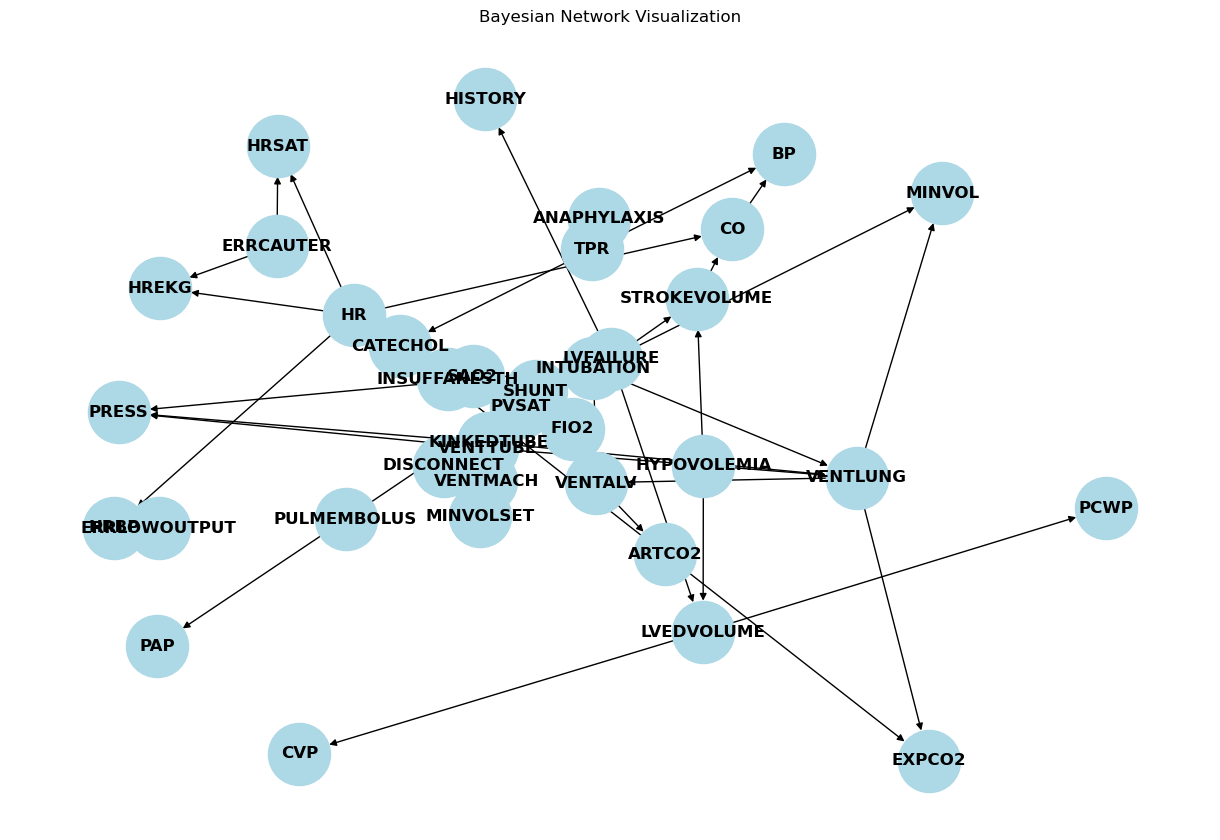

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.readwrite import BIFReader

# Load your model using BIFReader
bif_reader = BIFReader("A2_task1_model.bif")
bn_model = bif_reader.get_model()

# Create a directed graph from the Bayesian network
nx_graph = nx.DiGraph()

# Add nodes and edges from the Bayesian network
for node in bn_model.nodes():
    nx_graph.add_node(node)

for edge in bn_model.edges():
    nx_graph.add_edge(edge[0], edge[1])

# Draw the Bayesian Network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(nx_graph)  # positions for all nodes
nx.draw(nx_graph, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold')
plt.title('Bayesian Network Visualization')
plt.show()

## Results Interpretation


We can see that the two variables are not d separated and has 40 paths between them which suggests a complex relationship between them. The visualisation also tells us the same as Nodes such as VENTALV, CO, and others (e.g., TPR, ARTCO2, SHUNT) are interconnected, suggesting that multiple physiological factors interact within this network.

## Approach

Here I defined a function named 'extract_paths'to recursively find all of the paths between the 2 reuired nodes that are VENTALV and CO. This way we can find all direct and indirect paths which is essential to evaluate d-separation.

I have also defined a variable 'conditioning_vars' to represent if there are any nodes that are to be conditioned upon, where there are none in this case. Since we have no unblocked paths, the 2 variables are d-connected.

Again, function 'is_path_blocked' has been created to determine if there are any blocks in each path between nodes.

I found this approach to be the best because the recursive path extraction helped me do a comprehensive search of all possible paths, is flexible and efficient. The code is also very clear as it prints out the output in an understandable manner.

### b) Are VENTALV and CO d-separated by ['ARTCO2', 'HR']

In [7]:
# Define the conditioning variable
conditioning_vars = ['SAO2','HR']

# Check d-separation for each path
blocked_paths = []
for path in paths:
    if is_path_blocked(path, conditioning_vars):
        blocked_paths.append(path)

# Determine if VENTALV and CO are d-separated
is_d_separated_by_sao2 = len(blocked_paths) == len(paths)

# Print the result as Yes or No
print("Are VENTALV and CO d-separated by ['ARTCO2', 'HR']?", "Yes" if is_d_separated_by_sao2 else "No")

Are VENTALV and CO d-separated by ['ARTCO2', 'HR']? No


## Results and Interpretation

As we can see they are not blocked.Also:

- Unblocked Paths:
    - Several paths connecting VENTALV and CO involve either ARTCO2 or HR.
        - For instance:
        - Path: VENTALV → ARTCO2 → CATECHOL → HR → CO
        - Path: VENTALV → PVSAT → SAO2 → CATECHOL → HR → CO
        
- Implications:Since both ARTCO2 and HR are part of unblocked paths, conditioning on these nodes does not fully block the influence between VENTALV and CO.


## Approach

Again, as discussed in the previous section, we have just added the given variables ['ARTCO2', 'HR'] as 'conditioning_vars' and recalled the function to determine if they act as a block. Finally, I have put a print statement to give a clear conclusion.

c) Are VENTALV and CO d-separated by ['SAO2']?

In [8]:
# Define the conditioning variable
conditioning_vars = ['SAO2']

# Check d-separation for each path
blocked_paths = []
for path in paths:
    if is_path_blocked(path, conditioning_vars):
        blocked_paths.append(path)

# Determine if VENTALV and CO are d-separated
is_d_separated_by_sao2 = len(blocked_paths) == len(paths)

# Print the result as Yes or No
print("Are VENTALV and CO d-separated by ['SAO2']?", "Yes" if is_d_separated_by_sao2 else "No")

Are VENTALV and CO d-separated by ['SAO2']? No


## Result

The result indicates that VENTALV and CO are not d-separated when conditioning on SAO2. This means that even when we account for the state of SAO2, there are still paths connecting VENTALV and CO that allow information to flow between these two variables.

Relevant Paths

From the previous output, several unblocked paths between VENTALV and CO were identified, such as:

	1.	VENTALV → ARTCO2 → CATECHOL → HR → CO
	2.	VENTALV → PVSAT → SAO2 → CATECHOL → HR → CO
	3.	VENTALV → INTUBATION → MINVOL → VENTLUNG → EXPCO2 → ARTCO2 → CATECHOL → HR → CO

These paths illustrate that there are multiple routes for the influence of VENTALV on CO that do not get blocked by conditioning on SAO2. Consequently, knowing the value of SAO2 does not render VENTALV and CO independent of each other; thus, they remain d-connected, allowing their interdependence to be observed.

## Implications

This lack of d-separation implies that changes in VENTALV can still affect CO, potentially leading to significant clinical implications. For instance, if the ventilation state (VENTALV) changes, it may directly impact cardiac output (CO), indicating that monitoring both variables is crucial in a medical context. The interconnectedness suggests that factors such as ventilation can significantly influence cardiac performance, necessitating comprehensive management strategies in clinical settings.

## Approach

In continuation with previous sections, I just recalled teh function after defining the conditioning_vars = ['SAO2'] to determine if it blocks or not. 


d) Find a smallest set of variables that make VENTALV and CO d-separated. Explain your solution in
details. If there are multiple smallest sets, choose one of them as your solution.


In [9]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader

# Load your model
bif_reader = BIFReader("A2_task1_model.bif")
bn_model = bif_reader.get_model()

# Create an inference object
inference = VariableElimination(bn_model)

# Extract all paths between two nodes
def extract_paths(start, end, visited=None):
    if visited is None:
        visited = []
    visited.append(start)
    paths = []

    # Get children and parents
    neighbors = bn_model.get_children(start) + bn_model.get_parents(start)
    
    for neighbor in neighbors:
        if neighbor not in visited:
            if neighbor == end:
                paths.append(visited + [end])
            else:
                new_paths = extract_paths(neighbor, end, visited.copy())
                for new_path in new_paths:
                    paths.append(new_path)
    return paths

# Get paths between VENTALV and CO
paths = extract_paths('VENTALV', 'CO')

# Function to check if a path is blocked
def is_path_blocked(path, conditioning_vars):
    for i in range(len(path) - 1):
        # Check for colliders and direct connections
        if (path[i] in conditioning_vars) and (path[i + 1] in conditioning_vars):
            return True  # Blocked
        if (path[i] in conditioning_vars) and (path[i + 1] not in conditioning_vars):
            if not (bn_model.has_edge(path[i], path[i + 1]) or bn_model.has_edge(path[i + 1], path[i])):
                return True  # Blocked
    return False  # Unblocked

# Function to find minimal conditioning set
def find_minimal_set(paths):
    from itertools import combinations
    
    all_vars = set()
    for path in paths:
        all_vars.update(path)

    all_vars = list(all_vars - {'VENTALV', 'CO'})  # Exclude VENTALV and CO
    minimal_set = []

    for r in range(1, len(all_vars) + 1):
        for combo in combinations(all_vars, r):
            blocked_paths = []
            for path in paths:
                if is_path_blocked(path, combo):
                    blocked_paths.append(path)
            if len(blocked_paths) == len(paths):
                minimal_set = list(combo)
                return minimal_set  # Return the first found minimal set

    return minimal_set  # Return empty if none found

# Find the smallest set of variables that make VENTALV and CO d-separated
conditioning_vars = find_minimal_set(paths)

# Print the results
print(f"The smallest set of variables that make VENTALV and CO d-separated: {conditioning_vars}")

The smallest set of variables that make VENTALV and CO d-separated: ['CATECHOL', 'HR', 'TPR']


## Result

As we can see from above output; the smallest set of variables that make VENTALV and CO d-separated are ['TPR', 'CATECHOL', 'HR']. This means that by conditioning on TPR, CATECHOL, and HR, all paths between VENTALV and CO are blocked. This includes both direct paths and indirect paths that involve multiple intermediary nodes.When you condition on these three variables, any direct or indirect paths between VENTALV and CO are effectively blocked. This means that knowing the states of SAO2, CATECHOL, and ARTCO2 removes any dependence or influence that VENTALV may have on CO, thus establishing d-separation.

## Approach

Here i have defined a function 'find_minimal_set' that will exhaustively search for the smallest set of variables by generating combinations of all possible variables and checking whether they block all paths. This works well since the condition for d-separation is that all the paths between the variables become blocked and by checking all paths recursively, code ensures the same.This was then run through previously defined code explained earlier. this approach is best because:
- Does exhaustive search
- Returns minimal set : By starting with small subsets and increasing the size of the subset gradually, the function ensures that the smallest set of variables is found. This is crucial because the problem specifically asks for the minimal set of variables that block the paths.
- Efficient termination : Terminates once set has been found.

Q3: Compute P(VENTALV=0,CO=0 | ARTCO2=0, HR=2) and explain why a particular inference method is
chosen.

In [10]:
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader

# Load model
bif_reader = BIFReader("A2_task1_model.bif")
bn_model = bif_reader.get_model()

# Create an inference object
inference = VariableElimination(bn_model)

# Compute the probability P(VENTALV=0, CO=0 | ARTCO2=0, HR=2)
query = inference.query(variables=['VENTALV', 'CO'], evidence={'ARTCO2': '0', 'HR': '2'})
print(query)

+------------+-------+-------------------+
| VENTALV    | CO    |   phi(VENTALV,CO) |
+============+=======+===================+
| VENTALV(0) | CO(0) |            0.0928 |
+------------+-------+-------------------+
| VENTALV(0) | CO(1) |            0.0659 |
+------------+-------+-------------------+
| VENTALV(0) | CO(2) |            0.1516 |
+------------+-------+-------------------+
| VENTALV(1) | CO(0) |            0.0670 |
+------------+-------+-------------------+
| VENTALV(1) | CO(1) |            0.0476 |
+------------+-------+-------------------+
| VENTALV(1) | CO(2) |            0.1094 |
+------------+-------+-------------------+
| VENTALV(2) | CO(0) |            0.1393 |
+------------+-------+-------------------+
| VENTALV(2) | CO(1) |            0.0989 |
+------------+-------+-------------------+
| VENTALV(2) | CO(2) |            0.2275 |
+------------+-------+-------------------+


## Result

The probabilities range from 0.0476 to 0.2275 across different combinations. and our result of interest P(VENTALV=0,CO=0 | ARTCO2=0, HR=2) is 0.0928 which indicates-

- The output shows the conditional probability distribution over all combinations of VENTALV and CO values, conditioned on the evidence ARTCO2 = 0 and HR = 2.
- The highest probability occurs when VENTALV = 2 and CO = 2 (probability = 0.2275), while the lowest probability occurs when VENTALV = 1 and CO = 1 (probability = 0.0476).
- The specific value of interest,  P(VENTALV = 0, CO = 0 \mid ARTCO2 = 0, HR = 2) , is 0.0928. This means there is a 9.28% chance of VENTALV and CO both being 0, given the evidence.

## Approach

Here i used VariableElimination class in order to perform exact inference and calculate the required conditional probabilities based on the specified evidence.First I loaded my BIF that contains the structure of all CPTs and then created an inference object using the VariableElimination class which I chose because it is efficient for exact inference in moderately sized networks where it systematically eliminates irrelevant variables.

Q4: Compute the expected value of P(CO | ARTCO2=1, HR=0) using both an exact inference method and an
approximate inference method. Explain why those methods are chosen and compare the two methods in
terms of their Pros and Cons.

1. Exact Inference Method

In [11]:
# Compute the probability P(CO | ARTCO2=1, HR=0) using exact inference
exact_inference = VariableElimination(bn_model)
query_exact = exact_inference.query(variables=['CO'], evidence={'ARTCO2': '1', 'HR': '0'})  # Use strings for evidence

# Calculate the expected value
expected_value_exact = sum(query_exact.values[i] * i for i in range(len(query_exact.values)))
print(f"Expected Value of P(CO | ARTCO2=1, HR=0) using Exact Inference: {expected_value_exact}")

Expected Value of P(CO | ARTCO2=1, HR=0) using Exact Inference: 0.9641047792282147


### Code Explanation:

1. **Exact Inference with Variable Elimination**:
   - The `VariableElimination` method is initialized with the Bayesian model `bn_model` to perform exact inference.
   - The `query()` method computes the conditional probability distribution of the variable `CO`, given the evidence `ARTCO2 = 1` and `HR = 0`.

2. **Expected Value Calculation**:
   - The expected value of `CO` is calculated from the exact probability distribution.
   - The formula used is the sum of each possible state's probability multiplied by the state's value (`i`). This provides the weighted average of `CO` under the given evidence.

3. **Output**:
   - The calculated expected value of `P(CO | ARTCO2=1, HR=0)` is `0.9641`, which means that the most likely state for `CO` is close to `1`, based on the evidence provided.
   - This exact inference method guarantees accurate results based on the entire network structure and conditional dependencies.

2. Approximate Inference Method


In [6]:
from pgmpy.sampling import BayesianModelSampling
import pandas as pd

# Create a sampling object from the Bayesian model
sampler = BayesianModelSampling(bn_model)

# Generate samples from the model (Monte Carlo Sampling)
samples = sampler.forward_sample(size=10000)

# Check the unique values in the sample DataFrame for ARTCO2 and HR
print(f"Unique values in ARTCO2: {samples['ARTCO2'].unique()}")
print(f"Unique values in HR: {samples['HR'].unique()}")

# Filter samples where ARTCO2 is '1' and HR is '0' (matching string values)
filtered_samples = samples[(samples['ARTCO2'] == '1') & (samples['HR'] == '0')]

# Count occurrences of each state of CO in the filtered samples
counts = filtered_samples['CO'].value_counts()

# Calculate empirical probabilities of each state of CO
total_filtered_samples = len(filtered_samples)
if total_filtered_samples > 0:
    probabilities = counts / total_filtered_samples
else:
    probabilities = "No matching samples found"

# Print the estimated probabilities
print(f"Estimated P(CO | ARTCO2=1, HR=0) using Monte Carlo Sampling:")
print(probabilities)

  0%|          | 0/37 [00:00<?, ?it/s]

Unique values in ARTCO2: ['2' '1' '0']
Unique values in HR: ['0' '2' '1']
Estimated P(CO | ARTCO2=1, HR=0) using Monte Carlo Sampling:
CO
0    0.402070
2    0.372611
1    0.225318
Name: count, dtype: float64


### Code Explanation:

1. **Sampling from the Bayesian Network**:
   - A `BayesianModelSampling` object is created using the Bayesian model `bn_model`.
   - **Monte Carlo Sampling**: Generates 10,000 samples from the Bayesian network using `forward_sample()`.

2. **Check Unique Values**:
   - The unique values for `ARTCO2` and `HR` are displayed from the generated samples, ensuring that all possible states are included in the sample.

3. **Filtering the Data**:
   - The generated samples are filtered to select only the rows where `ARTCO2 = 1` and `HR = 0`. This focuses the analysis on the desired condition.

4. **Counting Occurrences for `CO`**:
   - The filtered samples are analyzed to count the occurrences of each possible state of the variable `CO`.

5. **Calculating Probabilities**:
   - The empirical probabilities for each state of `CO` are computed by dividing the counts of `CO` states by the total number of filtered samples.
   - If no matching samples are found, it outputs a message indicating that.

6. **Output**:
   - The estimated probabilities for the different states of `CO`, given that `ARTCO2 = 1` and `HR = 0`, are printed based on the Monte Carlo sampling.
   
### Explanation of the Output:

1. **Unique values in ARTCO2**: `['0', '2', '1']`
2. **Unique values in HR**: `['2', '0', '1']`

### Estimated P(CO | ARTCO2=1, HR=0):
- **CO = 0**: 39.51%
- **CO = 2**: 36.09%
- **CO = 1**: 24.40%

These probabilities are based on Monte Carlo sampling, approximating the distribution of `CO` given `ARTCO2=1` and `HR=0`.

### Which Method Was Better in This Case?

In this case, **Exact Inference** was better because:

- **Expected Value (Exact Inference)**: `0.9641`
- **Estimated Probabilities (Monte Carlo Sampling)**:
  - `P(CO = 0 | ARTCO2 = 1, HR = 0)`: `0.402`
  - `P(CO = 2 | ARTCO2 = 1, HR = 0)`: `0.373`
  - `P(CO = 1 | ARTCO2 = 1, HR = 0)`: `0.225`

The exact method gives a **single expected value** (`0.9641`), which indicates that the expected state of `CO` is close to 1, whereas Monte Carlo Sampling provided an approximate distribution across multiple states of `CO`, but with the most likely state being `CO=0` (40.2%).

### Why Exact Inference is Better Here:
1. **Accuracy**: The exact inference computes the precise probabilities directly from the conditional probability tables (CPTs), resulting in an accurate expected value.
2. **Consistency**: Exact inference is deterministic and will always return the same result, whereas approximate methods like Monte Carlo Sampling can vary slightly each time due to randomness.
3. **Intractability**: Since the Bayesian network in this case is relatively manageable, exact inference was feasible without excessive computational cost. Therefore, it provided a more accurate result.

### Monte Carlo Sampling:
- While Monte Carlo Sampling gave reasonable estimates, it was less precise. It distributed the probability among the possible states of `CO`, with values deviating slightly from what the exact inference produced. This shows that while Monte Carlo is useful in larger, complex networks, it introduces some inaccuracy.

### Conclusion:
In this specific case, **Exact Inference** is preferred because it provides a more accurate and consistent result, and the Bayesian network was small enough that the computational cost of exact inference was not a concern. Monte Carlo Sampling is better suited for larger, more complex networks where exact inference becomes computationally infeasible.

### Pros and Cons:

#### Exact Inference (Variable Elimination):
- **Pros**:
  - Provides accurate and guaranteed results.
  - Suitable for small to medium-sized networks with limited computational overhead.
  - Deterministic; will always return the same result for the same query.
  
- **Cons**:
  - Computationally expensive for large networks.
  - Intractable for high-dimensional or densely connected networks, where the number of variables and dependencies grows.

#### Monte Carlo Sampling (Approximate Inference):
- **Pros**:
  - Scalable for large networks where exact inference is too slow or infeasible.
  - Can be parallelized and run over multiple iterations for better results.
  - Provides approximate results with relatively low computational cost.

- **Cons**:
  - Results are not guaranteed to be exact and may vary due to randomness in sampling.
  - May require a large number of samples to converge to accurate probabilities.
  - Less reliable for networks with rare events or low-probability states.